---

# Gaussian Process

## Introduction

In the previous sections **parametric** and **non-parametric** supervised ML-methods have been introduced. In parametric algorithms, such as [Linear Regression](LinReg) one assumes a certain model type (e.g. the model is a linear function) and the algorithm learns the parameters of this model type (e.g. slope and bias) such that the concrete model fits well to the given training data. One the other hand a non-parametric approach such as [K-Nearest Neighbors](knn) does not require any assumptions about the model-type and it does not learn any parameters, that define a model. Instead it just saves all training data and predicts the output of new data by determining the nearest training instances.

Parametric methods are weak, if the assumption on the model-type is inadequate. After the training phase the entire knowledge of the training data is compressed in a few model parameters. This may constitute waste of information. For example, after training we do not know in which regions much training data has been available and hence predictions may have an increased reliabilty. The drawback of non-parametric methods is their large memory footprint and their long inference time. Moreover, since we do not have a model, predictions in regions, where no training-data has been available, are quite unreliable.

In this context a **Gaussian Process** can be considered to be a **semi-parametric** supervised ML-algorithm. In the inference phase the predictions are calculated from training data. It is not necessary to assume a certain model type (therefore non-parametric). However, on must assume a way how predictions are calculated from training data and possibly learn parameters, which specify this way (therefore parametric). 

Gaussian Processes can be applied for regression and classification. However, in practice they are mostly applied for regression. In this lecture only the regression-case is considered.


## Recap Gaussian Normal Distribution

A Gaussian Process is closely related to a **Multidimensional Gaussian Distribution**. Therefore, we first recall univariate and multivariate Gaussian distributions, before the Gaussian Process and it's application for Regression will be described.  

### Univariate

The Power Density Function (PDF) of a **Gaussian distribed random variable $X$** is: 

$$
p_X(x)=\frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{(x-\mu)^2}{2\sigma^2}}, 
$$ (gausspdfuni)

where $\mu$ is the mean and $\sigma$ is the standard deviation. This distribution is plotted below for two different standard deviations. 

```{figure} https://maucher.home.hdm-stuttgart.de/Pics/univariateGaussPDF.png
align: center
width: 600pt
name:  gausspdf

PDFs of univariate Gaussian distribution with different standard deviations.  
```

In the sequel a Gaussian distributed random variable $X$ with mean $\mu$ and standard deviation $\sigma$ is denoted by 

$$
X \sim \mathcal{N}(\mu,\sigma^2)
$$

**Estimate parameters from data:**

The univariate Gaussian distribution, as defined in equation {eq}`gausspdfuni` is completely defined by the parameters $\mu$ and $\sigma$. If a sample of $Z$ values $x_i$ of a univariate random variable $X$ are given and it can be assumed that the random variable is Gaussian distributed, the mean-value and the standard deviation can be estimated as follows.

Estimate for $\mu$:

$$
m=\frac{1}{Z}\sum\limits_{i=1}^Z x_i 
$$

Estimate for $\sigma$:

$$
s=\sqrt{\frac{1}{Z-1}\sum_{i=1}^Z (x_i-m)^2}.
$$




### Multivariate

The Power Density Function (PDF) of a **Multidimensional Gaussian Distribution** is:

$$
  p(\mathbf{x})=\frac{1}{(2 \pi)^{d/2} |\Sigma|^{1/2}} \exp\left[-\frac{1}{2}(\mathbf{x}- \boldsymbol\mu)^T \Sigma^{-1}(\mathbf{x}-\boldsymbol\mu)\right] , \quad -\infty < x < \infty 
$$ (gausspdfmulti)

Here 

* $\mathbf{x}=\left[x_1,x_2,\ldots,x_d \right]$ are the values of $d$ random variables, which are jointly Gaussian distributed.

* the **mean-value-vektor** is 

	$$
	\mathbf{\mu}=[\mu_1,\mu_2,\ldots, \mu_d]
	$$ (meanvec)
	
* the **covariance matrix** is

	$$ 
	\Sigma = \left(
	\begin{array}{cccc}
	\sigma_{11}^2 & \sigma_{12} &\cdots & \sigma_{1d} \\
	\sigma_{21} & \sigma_{22}^2 &\cdots & \sigma_{2d} \\
	\vdots      & \vdots      & \ddots &  \vdots \\
	\sigma_{d1} & \sigma_{d2} & \cdots & \sigma_{dd}^2 \\
	\end{array} \right)
	$$ (covmat)
	
	In this matrix the elements on the principal diagonal $\sigma_{ii}^2$ are the variances along the corresponding axis. All other elements are covariances, which describe the correlation between the axes. If $\sigma_{ij}=0$, then the random variables $X_i$ and $X_j$ are not correlated. The higher the absolute value of $\sigma_{ij}$, the stronger the correlation. From the variances and the covariances the **linear correlation-coefficient $\rho_{ij}$** can be calculated as follows:
	
	$$
	\rho_{ij}=\frac{\sigma_{ij}}{\sigma_{ii} \sigma_{jj}}
	$$ (corr)

	The correlation coefficient has a value-range from $-1$ to $1$ and helps to better *quantify* the correlation between the axis.

* $|\Sigma|$ is the determinant of the covariance matrix
* $\Sigma^{-1}$ is the inverse of the covariance matrix

Below, the PDF of a 2-dimensional Gaussian distribution with 

$$
\mathbf{\mu}=[0,0]
$$ 

and

$$
\Sigma = \left(
	\begin{array}{cc}
	1.5 & 0  \\
	0 & 1.5  \\
	\end{array} \right)
$$

is plotted.

```{figure} https://maucher.home.hdm-stuttgart.de/Pics/gauss2dimpdf.png
---
align: center
width: 400pt
name:  gausspdf
---
PDF of a 2-dimensional Gaussian distribution.  
```

**Estimate parameters from data:**

In order to estimate a multi-dimensional Gaussian distribution from a dataset $T$, the mean-value-vektor $\mathbf{\mu}$ and the covariance matrix $\mathbf{\Sigma}$ must be estimated. 

We denote the **estimation of the mean-value-vektor $\mu$** by $m=[m_1,m_2,\ldots m_N]$. The components of this vektor are just the columnwise mean-values of the datamatrix:

$$
m_i=\frac{1}{Z}\sum_{k=1}^Z x_{k,i} \quad \forall i \in \left\{ 1,N \right\}, 
$$

where $x_{k,i}$ is the value of random variable $X_i$ of instance $k$.

Moreover, the **estimation of the covariance matrix $\Sigma$** is denoted by $S$. And the components of $S$ are 

* the estimations of the variances $\sigma_{ii}^2$, which are denoted by $s_{ii}^2$
* the estimations of the covariances $\sigma_{ij}$, which are denoted by $s_{ij}$.

From a given dataset $T$ with $Z$ instances (rows) and $N$ random variables (columns), the variances and covariances are estimated as follows:

$$
s_{ii}^2=\frac{1}{Z-1}\sum_{k=1}^Z (x_{k,i}-m_i)^2
$$

$$
s_{ij}=\frac{1}{Z-1}\sum_{k=1}^Z (x_{k,i}-m_i) \cdot (x_{k,j}-m_j)
$$

Below for two distinct 2-dimensional Gaussian distributions the PDF and a corresponding data sample are visualized. In the first example the two random variables are uncorrelated, in the second plot correlated.

```{figure} https://maucher.home.hdm-stuttgart.de/Pics/2dimGaussSigma0.png
---
align: center
width: 600pt
name:  2dimgauss1
---
Left: PDF of a 2-dimensional Gaussian distribution with no correlation between the two random variables $X_1$ and $X_2$. Right: Sample of data, drawn from the PDF on the left hand side.  
```

```{figure} https://maucher.home.hdm-stuttgart.de/Pics/2dimGaussSigma1.png
---
align: center
width: 600pt
name:  2dimgauss2
---
Left: PDF of a 2-dimensional Gaussian distribution with strong positive correlation between the two random variables $X_1$ and $X_2$. Right: Sample of data, drawn from the PDF on the left hand side.  
```

## Gaussian Process

After recalling Multidimensional Gaussian Distributions, it's no big deal to understand Gaussian Processes. In a nutshell: Multidimensioanl Gaussian Distributions are distributions over a finite set of $d$ correlated random variables. A Gaussian Process extends this to an infinite set of random variables. The differences are listed in the two panels below: 

````{panels}

Multidimensional Gaussian Distribution
^^^
* Joint Distribution over d Gaussian Variables

	$$
	X=\left[ X_1,X_2,\ldots X_d \right]
	$$
	 
* At each index $i$, with $i \in \{1,\ldots,d\}$ a Gaussian distributed variable $X_i$ with mean $\mu_i$ and variance $\sigma_i$ is defined.
* The random variables $X_i$ and $X_j$ are correlated with covariance $\sigma_{ij}$
* Each subset of the $d$ random variables is again a Multidimensional Gaussian Distribution
* The  Multidimensional Gaussian Distribution is completely defined by it's mean-vector $\mathbf{\mu}=[\mu_1,\mu_2,\ldots, \mu_d]$ and it's covariance matrix $\Sigma$
---
Gaussian Process
^^^
* Distribution over continous functions
  
  $$
  f(x)
  $$

* For each $x$ with $-\infty < x < \infty$ a Gaussian distributed $f(x)$ with mean $m(x)$ and variance $k(x,x)$ is defined.
* The function values $f(x_i)$ and $f(x_j)$ are correlated with covariance $k(x_i,x_j)$
* Each finite subset of the infinity number of function values $f(x_i)$ is a Multidimensional Gaussian Distribution
* The Gaussian Process is completely defined by it's mean-function $m(x)$ and it's covariance function $k(x_i,x_j)$

````

```{admonition} Gaussian Process
A Gaussian Process is a Probabilistic Distribution over functions $f(x)$, with $-\infty < x < \infty$. Since there exists an infinite number of values for $x$ it can be considered as an infinite-dimensional Gaussian distribution. Each finite subset of function-values $f(x_1),f(x_2),\ldots,f(x_d)$ is a usual Multidimensional Gaussian Distribution.  
```

In the sequel a Gaussian Process with mean-function $m(x)$ and covariance function $k(x,x')$ is denoted by 

$$
f \sim \mathcal{GP}(m,k)
$$


### Covariance Function

The most common covariance-function $k(x,x')$ is the **squared exponential$$

$$
k(x,x')= \sigma_f^2 \cdot e^{- \frac{(x-x')^2}{2\ell^2}}
$$ (squaredexp)

Parameters and characteristics of this covariance function are

* The correlation between $f(x)$ and $f(x')$ decreases with increasing distance between $x$ and $x'$.
* **Length-Scale $\ell$**: The higher $\ell$ the slower the decrease of the correlation between $f(x)$ and $f(x')$ with increasing distance between $x$ and $x'$. A high value $\ell$ means strong correlation between neighbouring function-values. This yields *smooth* curves. Small values for $\ell$ means less correlation and the potential for high differences in neighbouring function-values.
* **Variance $\sigma_f^2$**. This is the maximal covariance value and defines the value on the main diagonal of the covariance-matrix. This hyperparameter should be large, if one can assume a strong deviation around the mean-value.

````{panels}

Length-scale $\ell=1.0$
^^^
```{figure} https://maucher.home.hdm-stuttgart.de/Pics/gaussianProcessSamplesZeroMean.png
High length-scale in squared-exponential covariance function
```
---
Length-scale $\ell=0.408$
^^^
```{figure} https://maucher.home.hdm-stuttgart.de/Pics/gaussianProcessSamplesZeroMeanTheta3.png
Smaller length-scale in squared-exponential covariance function
```

````

### Generate Samples of Gaussian Process

Even though functions assign one function value to each argument of a possibly **infinite domain**, in computer programs functions are evaluated always at a finite set of arguments. Therefore, in computer programs one can think of functions as tables, in which to each domain value $x$ a corresponding function value $f(x)$ is mapped. **Since in computer programs we always have finite subsets and any finite subset of a Gaussian Process is a Multidimensional Gaussisan Distribution, we can generate samples of a Gaussian Process in exactly the same was as we generate samples of a Multidimensional Gaussian Distribution.** For generating samples of a Multidimensional Gaussian Distribution we have to specify the mean vector ({eq}`meanvec`) and the covariance matrix ({eq}`covmat`). 

The mean-value vector is obtained by evaluating the mean function $m(x)$ at all $x_i$ of the domain.  

$$
\boldsymbol\mu=[\mu_1,\mu_2,\ldots, \mu_N]= [m(x_1), m(x_2), \ldots m(x_N)]
$$ (Kmue)

The covariance matrix is obtained by evaluating the covariance function $k(x,x')$ at all possible pairs of arguments, i.e. the entry in row $i$, column $j$ of the covariance matrix is $k(x_i,x_j)$.

$$
K=\left( 
\begin{array}{cccc}
k(x_1,x_1) & k(x_1,x_2) & \ldots & k(x_1,x_N) \\
k(x_2,x_1) & k(x_2,x_2) & \ldots & k(x_2,x_N) \\
\vdots     & \vdots     & \ddots & \vdots     \\
k(x_N,x_1) & k(x_N,x_2) & \ldots & k(x_N,x_N) \\ 
\end{array}
\right)
$$


 ```{admonition} Example: Calculation of mean-vector and covariance matrix
 :class: tip
    
	Assume that the domain has only 4 elements
	
	$$
	\mathbf{x}=[1,2,3,4]
	$$
	
	For the mean function 
	
	$$
	m(x)=\frac{x^2}{4}
	$$ 
	
	and the covariance function 
	
	$$
	k(x,x')=2 \cdot e^{-\frac{1}{2}(x-x')^2}
	$$
	
	the corresponding mean-vector and covariance matrix are:
	
	$$
	\boldsymbol\mu=[0.25, 1.0 , 2.25, 4.0]
	$$
	
	and 
	
	$$
	K=\left( 
	\begin{array}{cccc}
	2.0   &  1.213 & 0.271 & 0.022 \\
	1.213 & 2.0    & 1.213 & 0.271 \\
	0.271 & 1.213  &2.0    & 1.213 \\
	0.022 & 0.271  & 1.213 & 2.0   \\
	\end{array}
	\right),
	$$
	
	respectively.
 
 ```

#### Implementation: Generate Samples of GP

Below it is shown how samples of a Gaussian Process can be generated.

Generate domain, mean-vector and covariance-matrix:

In [1]:
import numpy as np
x=np.linspace(0,7,35) 
mx=0.5+x*np.sin(x)    
K=np.zeros((len(x),len(x)))
for i in range(len(x)):
    for j in range(i,len(x)):
        k=2*np.exp(-0.5*(x[i]-x[j])**2) #covariance function
        K[i][j]=k
        K[j][i]=k

Generate 3 samples of a Multidimensional Gausian Distribution

In [2]:
pointset=np.random.multivariate_normal(mx,K,3) #Erzeugt 3 Samples einer multivariaten
print(pointset)

[[ 1.34684176  0.98688974  0.8600011   1.00185168  1.39473183  1.97429704
   2.64724427  3.31076266  3.8683915   4.24151331  4.3770787   4.25108717
   3.86709428  3.25084107  2.44393257  1.49889766  0.47535374 -0.56483549
  -1.56464002 -2.4796916  -3.28331549 -3.96556645 -4.52573716 -4.96137341
  -5.25934462 -5.3941122  -5.33453784 -5.05533497 -4.5463375  -3.81468961
  -2.88060448 -1.77215769 -0.52485176  0.81269388  2.1711628 ]
 [-0.2457973  -0.20749268  0.03584151  0.47222111  1.06152124  1.75124857
   2.4937448   3.2531101   3.99703741  4.67997535  5.23092331  5.5567971
   5.56291273  5.18240765  4.40195376  3.27327441  1.90633111  0.44697003
  -0.95341578 -2.16711267 -3.11048718 -3.75115468 -4.10156929 -4.20248772
  -4.10249454 -3.84071102 -3.43835966 -2.90098876 -2.22826378 -1.42489353
  -0.50677192  0.49937508  1.55970485  2.63540558  3.68088485]
 [ 0.9133627   1.08139505  1.38319101  1.78797593  2.24776949  2.70593609
   3.1079496   3.41025868  3.5837011   3.61132566  3.48423127

Visualize the generated samples and the mean-function:

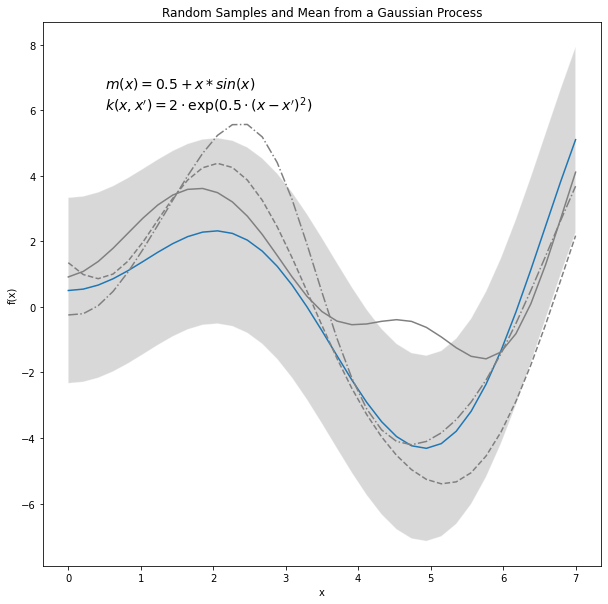

In [3]:
from matplotlib import pyplot as plt
from scipy import r_
plt.figure(figsize=(10,10))
plt.plot(x,mx,label="mean $m(x)=0.5+x*sin(x)$")
plt.plot(x,pointset[0],'--',color="gray")
plt.plot(x,pointset[1],'-.',color="gray")
plt.plot(x,pointset[2],color="gray")
plt.text(0.5,6,"$m(x)=0.5+x*sin(x)$ \n$k(x,x')=2 \cdot \exp(0.5\cdot(x-x')^2)$",fontsize=14)
plt.title('Random Samples and Mean from a Gaussian Process')
plt.xlabel('x')
plt.ylabel('f(x)')
fillx = r_[x, x[::-1]]
vars=np.diag(K)
stds=np.sqrt(vars)
filly = r_[mx+2*stds, mx[::-1]-2*stds[::-1]]
plt.fill(fillx, filly, facecolor='gray', edgecolor='white', alpha=0.3)
plt.show()

## Gaussian Process Regression

In the previous subsection it was described how samples of a Gaussian Process can be generated, given a mean-function and a covariance function. However, up to now nothing has been said, how this can be applied for a supervised ML regression task. The idea is that the Gaussian Process with defined mean- and covariance function constiute a **prior**. On the basis of this prior we calculate a **posterior** for the given training data 

$$
T=\{x_t,y_t \}_{t=1}^N
$$

In particular the given training data are considered to be support-points of a GP sample and we can calculate all other points $(x,f(x))$ on this particular GP sample from the mean- and covariance function and the given support-points. The prediction at an arbitrary argument $x$ is $f(x)$.  


```{figure} https://maucher.home.hdm-stuttgart.de/Pics/gaussianProcessPosteriorZeroMean.png
---
align: center
width: 600pt
name:  supportpoints
---
Training data is considered to constitute support-points (red) of a GP sample. By applying the mean- and covariance-function of the GP all other points of this sample (green dashed line) can be determined.
```

Recall that in [Linear Regression](LinReg), it is assumed that the output $y_t$ is the sum of a deterministic term $f(x_t)$ and a noise term $z_t$

$$
y_t=f(x_t)+n_t
$$

The noise term $n_t$ is assumed to be a sample of a 1-dimensional Gaussian distribution with zero mean and variance $\sigma_n^2$. In Linear Regression one tries to estimate a good approximation

$$
g(x)=w_0+w_1x_1+w_2x_2+\ldots+w_dx_d
$$

for the determinisic part $f(x)$. This approximation $g(x)$ minimizes the Mean Squared Error between the given labels $y$ and the model's prediction $g(x)$ on the training data.

Now in Gaussian Process Regression we assume that training data constitutes support-points on a sample of a Gaussian Process with predefined mean- and covariance function. In contrast to Linear Regression now the assumption is 

$$
y_t=f(x_t)+n_t+z_t,
$$ (gpass)

**where $z_t$ is considered to be a component of a sample of an N-dimensional Gaussian Distribution with zero mean.** As in Linear Regression $n_t$ is assumed to be a sample of a 1-dimensional Gaussian distribution with zero mean and variance $\sigma_n^2$. It is independent of all other training instances. The independent noise term $n_t$ and the correlated noise term $z_t$ can be integrated into a single Multidimensional Gaussian distribution by adding the term

$$
\sigma_n^2 \delta(x,x')
$$

to the covariance function $k(x,x')$, with the *Kronecker function*

$$
\delta(x,x')= \left\{ 
\begin{array}{lcl} 
1 & \mbox{ falls } & x=x' \\ 
0 & \mbox{ falls } & x \neq x'
\end{array}
\right.
$$

For example if the original covariance function is the squared exponential, as definied in equation {eq}`squaredexp` the new covariance function which integrates the noise term is 

$$
k_n(x,x')= \sigma_f^2 \cdot e^{- \frac{(x-x')^2}{2\ell^2}} + \sigma_n^2 \delta(x,x')
$$ (squaredexpex)

If the covariance-matrix is calculated with this noise-integrating covariance function the difference to the covariance matrix without noise-integration is, that now the values of the main diagonal are $\sigma_f^2+\sigma_n^2$, rather than $\sigma_f^2$.   


The main differences between GP Regression and Linear Regression are:

* in GP Regression the covariances between the training-instances are regarded, i.e. dependecies between neighboring training instances are taken into account.
* in GP Regression the goal is not to learn an approximation for $f(x)$. Instead, the values $y_*$ at the arguments of interest $x_*$ are estimated directly.



{cite}`Ebden2015`, {cite}`Rasmussen`